In [66]:
import sys
sys.path.append('/home/nadzya/Apps/log-anomaly-detector/')

import logging

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [84]:
import pandas as pd
import numpy as np 
import datetime
import json

from anomaly_detector.config import Configuration
from anomaly_detector.storage.mongodb_storage import MongoDBStorage
from anomaly_detector.storage.storage_attribute import MGStorageAttribute

from bson.json_util import dumps

from sklearn.cluster import DBSCAN, AffinityPropagation
from sklearn.decomposition import PCA
from gensim.models import Word2Vec
import re

In [260]:
def config():
    """Initialize configurations before testing."""
    cfg = Configuration()
    cfg.MG_HOST = "172.17.18.83"
    cfg.MG_PORT = 27017
    cfg.MG_CERT_DIR = ""
    cfg.MG_INPUT_DB = "anomalydb"
    cfg.MG_INPUT_COL = "utm_anomaly"
    cfg.HOSTNAME_INDEX = "hostname"
    cfg.DATETIME_INDEX = "timestamp"
    cfg.MG_CA_CERT = "/home/nadzya/Apps/log-anomaly-detector/config_files/LAD_CA.crt"
    cfg.MG_USER = 'dbadmin'
    cfg.MG_PASSWORD = 'password123'
    cfg.AGGR_VECTOR_LENGTH = 25
    cfg.AGGR_WINDOW = 5
    cfg.AGGR_EPS = 0.1
    cfg.AGGR_MIN_SAMPLES = 2
    return cfg

In [261]:
class DataCleaner:
    """Data cleaning utility functions."""

    @classmethod
    def _clean_message(cls, line):
        """Remove all none alphabetical characters from message strings."""
        words = list(re.findall("[a-zA-Z]+", line))
        return words
        
    @classmethod
    def _preprocess(cls, data):
        """Provide preprocessing for the data before running it through W2V and SOM."""
        def to_str(x):
            """Convert all non-str lists to string lists for Word2Vec."""
            ret = " ".join([str(y) for y in x]) if isinstance(x, list) else str(x)
            return ret

        for col in data.columns:
            if col == "message":
                data[col] = data[col].apply(cls._clean_message)
            else:
                data[col] = data[col].apply(to_str)

        data = data.fillna("EMPTY")

    @classmethod
    def format_log(cls, config, es_dataset):
        """Format log will extract prefix out of the message."""
        if config.LOG_FORMATTER == "strip_prefix":
            for es_data in es_dataset:
                try:
                    if len(es_data['message'].split("] ")) > 1:
                        es_data["orig_message"] = es_data["message"]
                        es_data["message"] = es_data["message"].split("] ")[1]
                except Exception as ex:
                    logging.debug("Error {} in log formatter: {}".format(ex, config.ES_LOG_FORMATTER))

In [262]:
class MongoDBDataStorageSource(DataCleaner, MongoDBStorage):
    """MongoDB data source implementation."""

    NAME = "mg.source"

    def __init__(self, config):
        """Initialize mongodb storage backend."""
        self.config = config
        MongoDBStorage.__init__(self, config)

    def retrieve(self, storage_attribute: MGStorageAttribute):
        """Retrieve data from MongoDB."""

        mg_input_db = self.mg[self.config.MG_INPUT_DB]
        now = datetime.datetime.now()

        mg_data = mg_input_db[self.config.MG_INPUT_COL]

        if self.config.LOGSOURCE_HOSTNAME != 'localhost':
            query = {
                self.config.DATETIME_INDEX:  {
                    '$gte': now - datetime.timedelta(seconds=storage_attribute.time_range),
                    '$lt': now
                },
                self.config.HOSTNAME_INDEX: self.config.LOGSOURCE_HOSTNAME
            }
        else:
            query = {
                self.config.DATETIME_INDEX:  {
                    '$gte': now - datetime.timedelta(seconds=storage_attribute.time_range),
                    '$lt': now
                }
            }
        mg_data = mg_data.find(query).sort(self.config.DATETIME_INDEX, -1).limit(storage_attribute.number_of_entries)
        self.mg.close()

        if not mg_data.count():   # if it equials 0:
            return pandas.Dataframe(), mg_data

        mg_data = dumps(mg_data, sort_keys=False)

        mg_data_normalized = pd.DataFrame(pd.json_normalize(json.loads(mg_data)))
    
        self._preprocess(mg_data_normalized)

        return mg_data_normalized, json.loads(mg_data)

In [263]:
def get_lad_word2vec(config, df):
    w2v = W2VModel(config)
    w2v.create(df, config.AGGR_VECTOR_LENGTH, config.AGGR_WINDOW)
    return (w2v.one_vector(df), w2v.model["message"].wv)

In [264]:
def get_gensin_w2v(config, df):
    w2v = Word2Vec(sentences=list(df["message"]), size=config.AGGR_VECTOR_LENGTH, window=config.AGGR_WINDOW)
    
    vectors = []
    for x in list(df["message"]):
        temp = []
        for word in x:
            if word in w2v.wv:
                #print(len(w2v.wv[word]))
                temp.append(w2v.wv[word])
            else:
                temp.append(np.array([0]*config.AGGR_VECTOR_LENGTH))
        vectors.append(temp)
    return vectors

In [265]:
def log_words_to_vector(log_list):
    result = []
    log_array_transposed = np.array(log_list, dtype=object).transpose()
    for coord in log_array_transposed:
        result.append(np.mean(coord)) 
    return result

In [266]:
def all_logs_to_vectors(logs):
    result = []
    for log in logs:
        result.append(log_words_to_vector(log))
    return np.array(result)

In [267]:
def add_cluster_label_to_df_dbscan(config, df, vectors):
    dbscan = DBSCAN(eps=config.AGGR_EPS, min_samples=cfg.AGGR_MIN_SAMPLES)
    clusters = dbscan.fit_predict(vectors)
    df["cluster_db"] = clusters
    return clusters

In [268]:
def add_cluster_label_to_df_ap(config, df, vectors):
    ap = AffinityPropagation(random_state=0, max_iter=2)
    clusters = ap.fit_predict(vectors)
    df["cluster_ap"] = clusters
    return clusters

In [269]:
def aggregate_logs(df, df_json, clusters):
    aggregated = []
    for cluster in np.unique(clusters):
        messages = []
        for i in list(df.loc[df['cluster_db'] == cluster].index):
            messages.append(df_json[i]["message"])

        if cluster == -1:
            for msg in messages:
                aggregated.append((msg, 1, []))
                #aggregated.append(msg)
        else:
            splited_messages = [x.split() for x in messages]
            splited_transpose = [list(row) for row in zip(*splited_messages)]
            result_string = ""
            var_num = 0

            for x in splited_transpose:
                if len(set(x)) == 1:
                    result_string += x[0] + " "
                else:
                    result_string += "***" + " "

            msg_num = len(messages)
            aggregated.append((result_string[:-1], msg_num, messages))
            #aggregated.append(result_string[:-1])

    return aggregated

In [270]:
cfg = config()
mg = MongoDBDataStorageSource(cfg)
df, json_logs = mg.retrieve(MGStorageAttribute(30*86400, 500))

<ipython-input-262-5062e907c919>:37: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  if not mg_data.count():   # if it equials 0:


In [271]:
df = pd.DataFrame(df["message"])
vectors = get_gensin_w2v(cfg, df)

In [272]:
mean_vectors = all_logs_to_vectors(vectors)

# DBSCAN

In [273]:
clusters = add_cluster_label_to_df_dbscan(cfg, df, mean_vectors)
clusters

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  1,
        1,  0,  1,  0, -1,  0,  2,  2,  2,  2,  2,  2,  2,  0,  0,  0,  0,
        0,  0,  0,  2,  2,  2,  2,  0,  2,  2,  2,  0,  0,  0,  0,  0,  2,
        2,  2,  2,  2,  2,  2,  1,  1,  1,  1,  1,  0,  0,  2,  2,  2,  2,
        0,  2,  2,  0,  1,  0,  1,  1,  1,  0,  1,  1,  0,  1,  1,  0,  1,
        2,  3,  3,  3,  2,  3,  3,  3,  2,  3,  3,  3,  2,  3,  3,  3,  2,
        3,  3,  3,  2,  3,  3,  3,  0,  0,  0,  0,  2,  3,  3,  3,  0,  2,
        3,  3,  3,  2,  3,  3,  3,  2,  3,  3,  3,  0,  2,  3,  3,  3,  2,
        3,  3,  3,  2,  3,  3,  3,  0,  0,  2,  2,  2,  2,  2,  2,  0,  2,
        0,  0,  0,  0,  0,  0,  0,  0,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  4

Populating the interactive namespace from numpy and matplotlib


/home/nadzya/Apps/venv/lib/python3.8/site-packages/matplotlib/collections.py:1113: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if num == "auto":


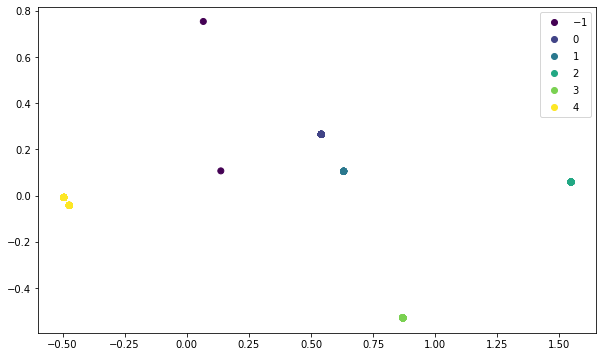

In [274]:
%pylab inline

pca = PCA(n_components=2, random_state=0)
data_2d_pca = pca.fit_transform(mean_vectors)

pylab.figure(figsize=(10, 6))
scat = pylab.scatter(data_2d_pca[:, 0], data_2d_pca[:, 1], c=list(df["cluster_db"]))
pylab.legend(*scat.legend_elements(num=np.unique(clusters)))

In [293]:
[json_logs[i] for x in list(df.loc[df["cluster_db"] == 4]["message"])]

['date time devname SLX FG VM devid FGVM logid type event subtype system level information vd root eventtime tz logdesc DHCP Ack log interface port dhcp msg Ack mac A D ip lease hostname influxdb msg DHCP server sends a DHCPACK',
 'date time devname SLX FG VM devid FGVM logid type event subtype system level information vd root eventtime tz logdesc DHCP Ack log interface port dhcp msg Ack mac A D ip lease hostname influxdb msg DHCP server sends a DHCPACK',
 'date time devname SLX FG VM devid FGVM logid type event subtype system level information vd root eventtime tz logdesc DHCP Ack log interface port dhcp msg Ack mac A D ip lease hostname influxdb msg DHCP server sends a DHCPACK',
 'date time devname SLX FG VM devid FGVM logid type event subtype system level information vd root eventtime tz logdesc DHCP Ack log interface port dhcp msg Ack mac A D ip lease hostname influxdb msg DHCP server sends a DHCPACK',
 'date time devname SLX FG VM devid FGVM logid type event subtype system level i

In [292]:
np.unique([np.array(mean_vectors[i]) for i in list(df.loc[df["cluster_db"] == 4].index)], axis=0)

array([[ 0.49571178, -0.09883444, -0.10649333,  0.50573578, -0.36498162,
        -0.16527369, -0.20243931,  0.02482844, -0.01470644, -0.70758204,
        -0.20217696,  0.19158167,  0.3753209 ,  0.59868612,  0.21725355,
        -0.27102398,  0.4507473 ,  0.06342559, -0.71764287, -0.51508175,
        -0.00293707,  0.29042921,  0.00823033,  0.00513457, -0.23693635],
       [ 0.49613568, -0.10833313, -0.10950711,  0.50756783, -0.37233829,
        -0.17569829, -0.1926545 ,  0.03287782, -0.00961985, -0.7225368 ,
        -0.20249532,  0.20432175,  0.38056891,  0.60053878,  0.19389268,
        -0.27477471,  0.44817586,  0.06012125, -0.70552158, -0.52889805,
         0.00805677,  0.2803542 ,  0.00861123,  0.00221878, -0.26494077]])

In [289]:
aggregate_logs(df, json_logs, clusters)

[('<13>Dec  7 15:06:56 U22020000000877 vectra_standard_campaigns -: CAMPAIGN [campaign@41261 id="1272" action="ADD" reason="Connection" dvc="172.17.18.39" dvchost="172.17.18.39" detectionId="None" hostname="dvasilev" currentIP="172.17.17.130" source_id="100" URL="https://172.17.18.39/campaigns/1272" dstHost="ut.rktch.com" DestinationIP="89.108.97.2" destID="external" timestamp="1638871903.0"]',
  1,
  []),
 ('<189>date=2021-12-05 time=11:57:00 devname="SLX-FG-VM-166" devid="FGVM010000010982" logid="0100040704" type="event" subtype="system" level="notice" vd="root" eventtime=1638694621914706118 tz="+0300" logdesc="System performance statistics" action="perf-stats" cpu=2 mem=80 totalsession=106 disk=1 bandwidth="70/362" setuprate=3 disklograte=0 fazlograte=0 freediskstorage=28507 sysuptime=20698557 msg="Performance statistics: average CPU: 2, memory:  80, concurrent sessions:  106, setup-rate: 3"',
  1,
  []),
 ('<46>Dec *** *** U22020000000877 -- MARK --',
  72,
  ['<46>Dec  7 07:15:26 

# Affinity Propogation

In [290]:
ap = AffinityPropagation(random_state=0)
clusters_ap = ap.fit_predict(mean_vectors)
clusters_ap

/home/nadzya/Apps/venv/lib/python3.8/site-packages/sklearn/cluster/_affinity_propagation.py:250: ConvergenceWarning: Affinity propagation did not converge, this model will not have any cluster centers.
  warnings.warn(


array([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1